# This notebook generates the data and runs Monte Carlo chains using CMBLensing.jl

##### Notebook adapted from Marius Millea's CMBLensing.jl tutorials

In [69]:
using CMBLensing, PythonPlot, FFTW, CUDA, FFTW, NPZ, Adapt, Statistics

In [3]:
CUDA.device(), CUDA.functional()

(CuDevice(0), true)

## Compute spectra

First, we compute the fiducial CMB power spectra which generate our simulated data,

In [4]:
Cℓ = camb(r=0.04,ℓmax=10000);

In [7]:
npzwrite("data/C_ell.npy",(Cℓ.total.ϕϕ.ℓ .* (Cℓ.total.ϕϕ.ℓ.+1) ./ 2. ).^2. .* Cℓ.total.ϕϕ.Cℓ)

Next, we chose the noise power-spectra:

In [8]:
Cℓn = noiseCℓs(μKarcminT=1., ℓknee=100., αknee = 3.);

Plot these up for reference,

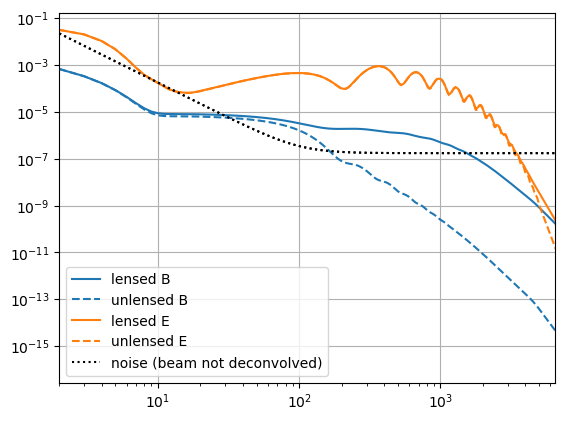

Python: (2, 6500)

In [12]:
loglog(Cℓ.total.BB,c="C0")
loglog(Cℓ.unlensed_total.BB,"--",c="C0")
loglog(Cℓ.total.EE,c="C1")
loglog(Cℓ.unlensed_total.EE,"--",c="C1")
loglog(Cℓn.BB,"k:")
loglog(Cℓn.EE,"k:")
# loglog(Cℓn.TT,"k:")
legend(["lensed B","unlensed B","lensed E","unlensed E", "noise (beam not deconvolved)"]);
grid()
xlim(2,6500)

## Configure the type of data

These describe the setup of the simulated data we are going to work with (and can be changed in this notebook),

In [13]:
θpix  = 2.        # pixel size in arcmin
Nside = 256    # number of pixels per side in the map
pol   = :P    # type of data to use (can be :T, :P, or :TP)
T     = Float32  # data type (Float32 is ~2 as fast as Float64);

Float32

In [14]:
kx = 2*π * cu(fftfreq(Nside,1/deg2rad(θpix/60.)));
ky = 2*π * cu(rfftfreq(Nside,1/deg2rad(θpix/60.)));
kx = repeat(kx,1,size(ky)...)
ky = reshape(ky,(1,size(ky)...))
ky = repeat(ky,Nside,1)
kgrid = (sqrt.(kx .* kx + ky .* ky) .+ 0im)
kgrid[1,1] += 1.
kgrid = cu(FlatFourier(kgrid',Nx=Nside,Ny=Nside,θpix  = 2.));
kgrid2 = kgrid .* kgrid

## Generate simulated data

In [40]:
(;f, f̃, ϕ, ds) = load_sim(
    seed = 4,
    storage=CuArray,
    fiducial_θ = (;Aϕ=1.0,r=0.04),
    μKarcminT=1., ℓknee=100., αknee = 3.,
    θpix = θpix,
    T = T,
    Nside = Nside,
    pol = pol,
    beamFWHM = 2.,
    bandpass_mask = LowPass(5000,Δℓ=0),
    pixel_mask_kwargs = (;apodization_deg=0.6,edge_padding_deg=0.4,num_ptsrcs=0)
)

(;Cf, Cϕ) = ds;

In [105]:
ℓ2 = FlatFourier(ϕ.ℓmag,Ny=256,θpix = θpix).^2;

In [55]:
# using Random
# using Distributions
# for i in range(0,64)
#     print(i)
#     N = 512;

#     rs = rand(Uniform(sqrt(1e-6),sqrt(1e-1)),N).^2.
    
#     ϕs = batch([simulate(ds.Cϕ(Aϕ=1.0)) for i=1:N]);
    
#     κs = (LowPass(5000,Δℓ=0) * ϕs) .* ℓ2 / 2
#     npzwrite("data/FlatLensingMaps_1PARAM_Kappa_$i.npy", cpu(κs[:Ix]))
#     κs = 0.

#     fs = batch([simulate(ds.Cf(r=rs[i])) for i=1:N]);
    
#     f̃s = LenseFlow(ϕs) * fs;
#     fs = 0.
#     ϕs = 0.
#     f̃s = (ds.M * (ds.B * f̃s));

#     ns = batch([simulate(ds.Cn) for i=1:N]);
#     f̃s = f̃s + ns;
#     ns = 0.

#     npzwrite("data/FlatLensingMaps_1PARAM_Q_Lensed_$i.npy", cpu(f̃s[:Qx]))
#     npzwrite("data/FlatLensingMaps_1PARAM_U_Lensed_$i.npy", cpu(f̃s[:Ux]))
    
#     f̃s = 0.
# end

01

## Examine simulated data

In [56]:
(;f, f̃, ϕ, ds) = load_sim(
    seed = 4,
    storage=CuArray,
    fiducial_θ = (;Aϕ=1.0,r=0.04),
    μKarcminT=1., ℓknee=100., αknee = 3.,
    θpix = θpix,
    T = T,
    Nside = Nside,
    pol = pol,
    beamFWHM = 2.,
    bandpass_mask = LowPass(5000,Δℓ=0),
    pixel_mask_kwargs = (;apodization_deg=0.6,edge_padding_deg=0.4,num_ptsrcs=0)
)

(;Cf, Cϕ) = ds;

The true $\phi$ and $\kappa$ map,

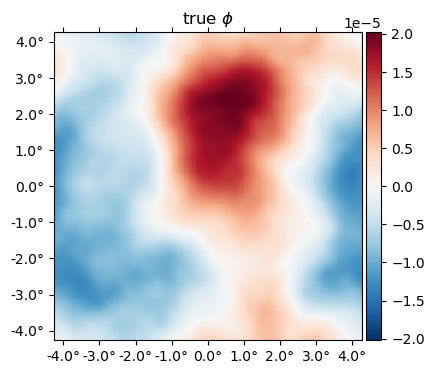

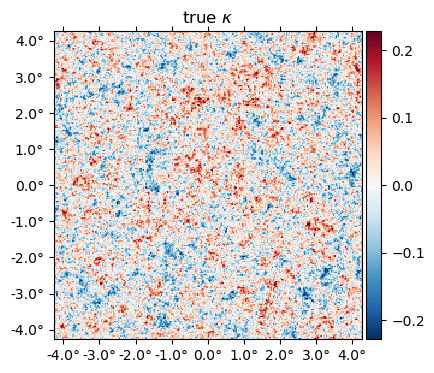

In [57]:
plot(ϕ, title = raw"true $\phi$");
plot(ϕ.* ℓ2 / 2, title = raw"true $\kappa$");

The "true" unlensed field, $f$,

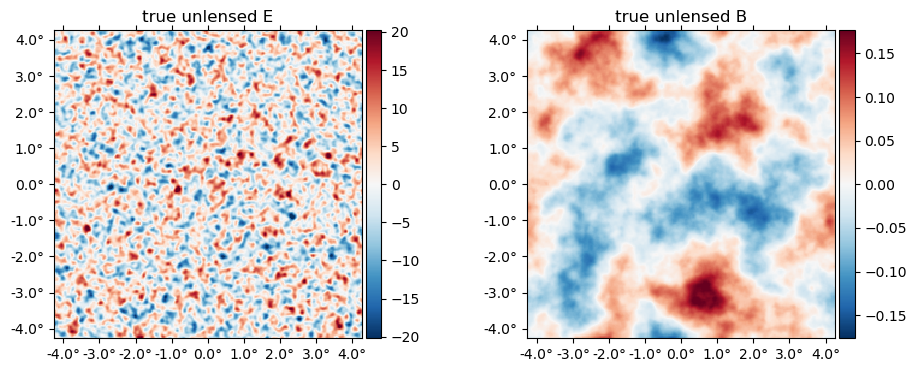

In [58]:
plot(f, title = "true unlensed " .* ["E"  "B"]);

And the "true" lensed field,

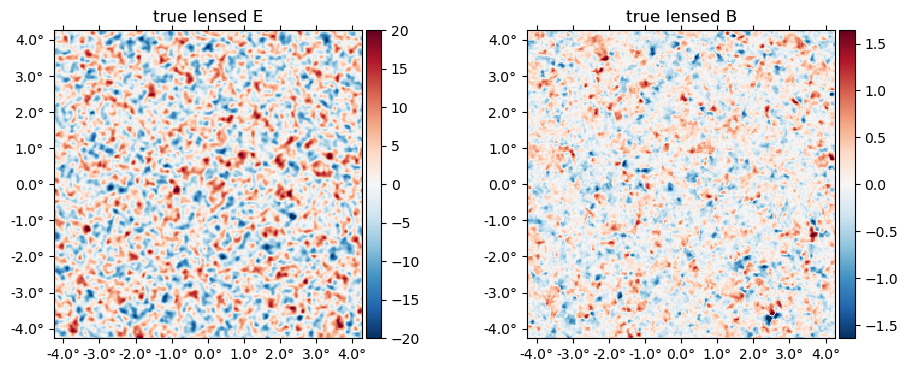

In [59]:
plot(Fourier(f̃), title = "true lensed " .* ["E" "B"]);

The data (stored in the `ds` object) is basically `f̃` with a beam applied plus a sample of the noise,

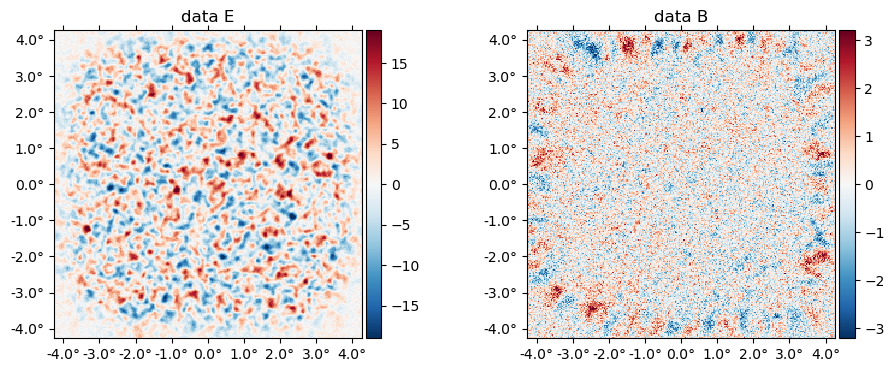

In [60]:
plot(ds.d, title = "data " .* ["E" "B"]);

# Run the optimizer

Now we compute the maximum of the joint posterior, $\mathcal{P}\big(f, \phi \,\big|\,d\big)$

In [61]:
fJ, ϕJ, history = MAP_joint(ds(); nsteps=30, progress=true, );

MAP_joint: 100%|████████████████████████████████████████| Time: 0:00:55
  step:        30
  logpdf:      1781313.00
  α:           0.15170486
  ΔΩ°_norm:    4.2e-06
  CG:          2 iterations (0.02 sec)
  Linesearch:  14 bisections (0.17 sec)


In [62]:
(;ϕqe, AL, Nϕ) = quadratic_estimate(ds);

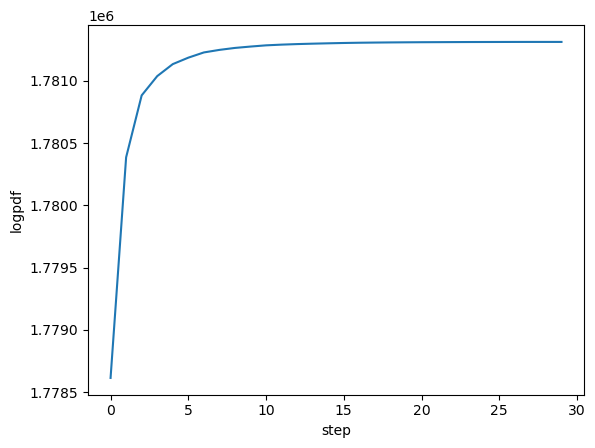

In [63]:
plot(getindex.(history, :logpdf))
xlabel("step")
ylabel("logpdf");

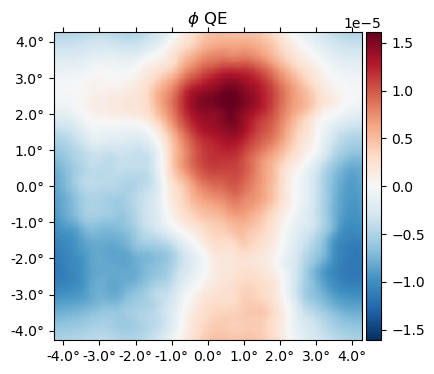

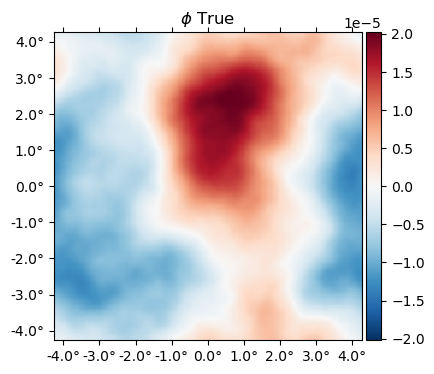

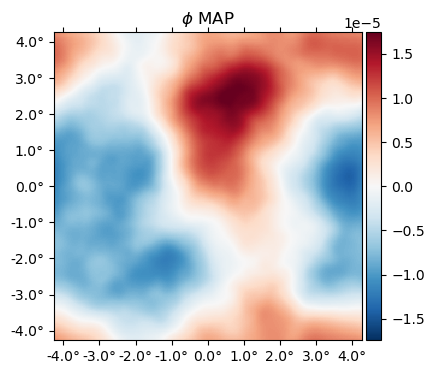

In [65]:
plot(ϕqe,title=raw"$\phi$ QE")
plot(ϕ,title=raw"$\phi$ True")
plot(ϕJ,title=raw"$\phi$ MAP")

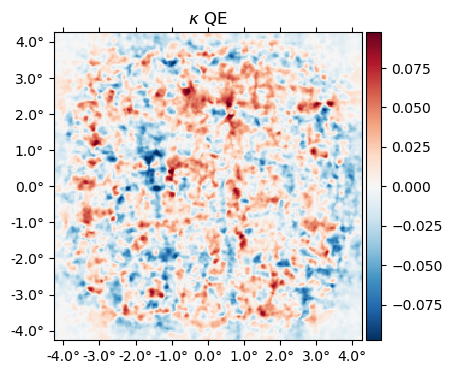

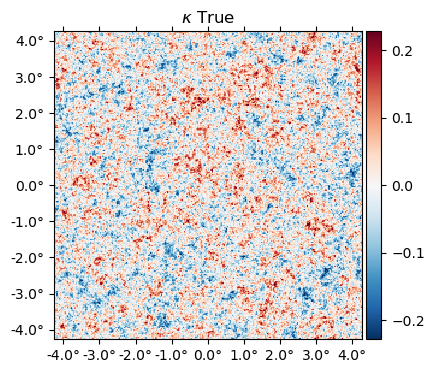

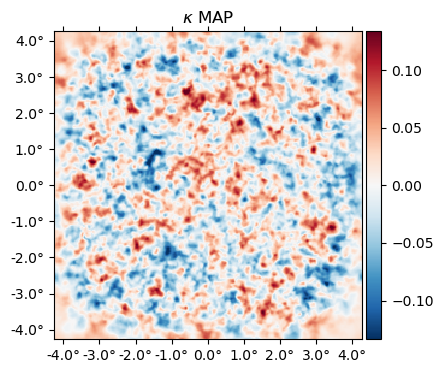

In [67]:
κqe = Fourier(ϕqe).*ℓ2/2 
κ = Fourier(ϕ).*ℓ2/2 
κJ = Fourier(ϕJ).*ℓ2/2

plot(κqe, title=raw"$\kappa$ QE")
plot(κ, title=raw"$\kappa$ True")
plot(κJ, title=raw"$\kappa$ MAP")

In [68]:
npzwrite("data/FlatLensingMaps_1PARAM_Q_Lensed_val_seed4.npy", cpu(ds.d)[:Qx])
npzwrite("data/FlatLensingMaps_1PARAM_U_Lensed_val_seed4.npy", cpu(ds.d)[:Ux])

npzwrite("data/FlatLensingMaps_1PARAM_Kappa_val_seed4.npy", cpu(κ)[:Ix])
npzwrite("data/FlatLensingMaps_1PARAM_Kappa_QE_val_seed4.npy", cpu(κqe)[:Ix])
npzwrite("data/FlatLensingMaps_1PARAM_Kappa_MAP_val_seed4.npy", cpu(κJ)[:Ix])

## Now run a HMC Gibbs chain

In [98]:
sample_joint(ds,nsamps_per_chain=17000, gibbs_samplers = [
        gibbs_sample_f!,
        gibbs_mix!,
        gibbs_sample_ϕ!,
        gibbs_sample_slice_θ!(:r) |> once_every(5) |> start_after_burnin(100),
        gibbs_unmix!,
        gibbs_postprocess!
    ],θstart=(Aϕ=1.,), θrange=(r=range(sqrt(1e-6),sqrt(1e-1),length=100).^2,),nchains=1,storage=CuArray,resume=true,filename="data/chains_1_1PARAM_seed4.jld2",progress=:summary);

Gibbs chain: 100%|██████████████████████████████████████| Time: 1:13:51
  step:    17000
  timing:  [0.25, 0.00, 1.00, 1.30, 0.00, 0.00]
  logpdf:  1703733.50
  ΔH:      0.0
  r:       0.02105105332177038


In [71]:
chain = load_chains("data/chains_1_1PARAM_seed4.jld2",join=true,progress=true,thin=5);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


In [72]:
N_samples = length(chain)

3400

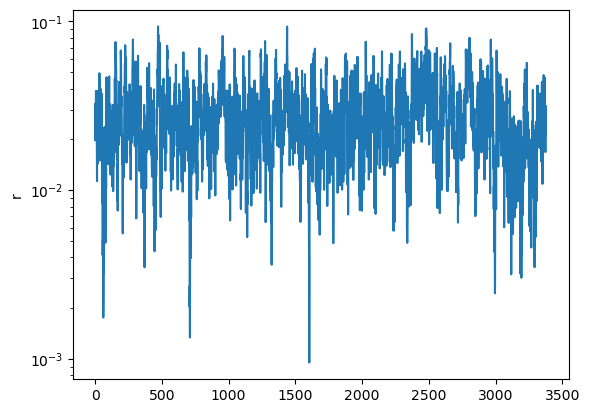

Python: Text(24.000000000000007, 0.5, 'r')

In [78]:
semilogy(chain[:θ,:r][22:N_samples])
ylabel('r')

In [79]:
mean(chain[:θ,:Aϕ][100:N_samples]), mean(chain[:θ,:r][100:N_samples])

(1.0, 0.027700075697335524)

In [80]:
N_samples = length(chain)

κs = [Array(cpu((LowPass(3000,Δℓ=0) * cu(chain[:ϕ][i]).* ℓ2 /2))[:Ix]) for i=201:N_samples];
length(κs)

3200

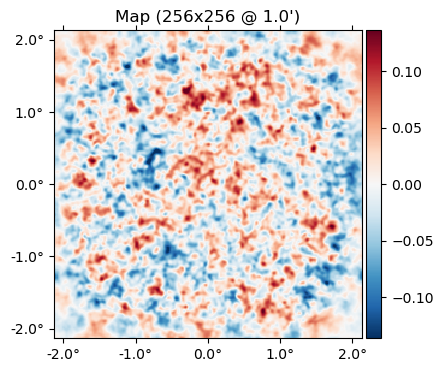

In [81]:
plot(FlatMap(mean(κs)))

In [82]:
npzwrite("data/samples_julia_1PARAM_seed4.npy",cat(κs...,dims=3))

In [83]:
cell_true = get_ℓ⁴Cℓ(cu(ϕ/2)).Cℓ;
cell_MAP = get_ℓ⁴Cℓ(cu(ϕJ/2)).Cℓ;

In [84]:
cells = [get_ℓ⁴Cℓ(cu(chain[:ϕ][i]/2)).Cℓ for i=1:N_samples];

In [85]:
ells = get_ℓ⁴Cℓ(cu(chain[:ϕ][1]/2)).ℓ;

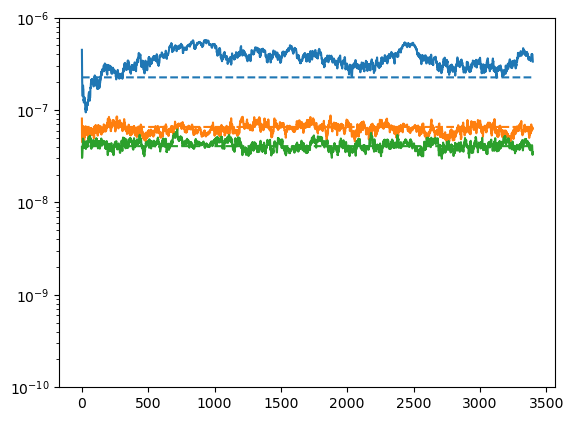

Python: (1e-10, 1e-06)

In [104]:
Nbin = 1
semilogy([cells[i][Nbin] for i=1:N_samples],color="tab:blue")
semilogy(cell_true[Nbin] .* range(1,N_samples) ./ range(1,N_samples),"--",color="tab:blue")


Nbin = 5
semilogy([cells[i][Nbin] for i=1:N_samples],color="tab:orange")
semilogy(cell_true[Nbin] .* range(1,N_samples) ./ range(1,N_samples),"--",color="tab:orange")

Nbin = 8
semilogy([cells[i][Nbin] for i=1:N_samples],color="tab:green")
semilogy(cell_true[Nbin] .* range(1,N_samples) ./ range(1,N_samples),"--",color="tab:green")
# semilogy(cell_MAP[Nbin] .* range(1,N_samples) ./ range(1,N_samples))
ylim(1e-10,1e-6)
# title("ℓ = $(ells[Nbin])")